In [1]:
import os, json, numpy as np, pandas as pd
from joblib import load, dump
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import scipy.sparse as sp
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt

In [2]:
base_dir = r"D:\Path\to\the\directory\where\the\extracted_mimic_iii_data\is\stored"
data_dir = os.path.join(base_dir, "CLEAN")
adv_dir = os.path.join(base_dir, "adv_models")
art_dir = os.path.join(base_dir, "ART"); os.makedirs(art_dir, exist_ok=True)

In [3]:
train = pd.read_csv(os.path.join(data_dir, "train_clean.csv"))
test = pd.read_csv(os.path.join(data_dir, "test_clean.csv"))
with open(os.path.join(data_dir, "preprocess_metadata.json"), "r") as f:
    meta = json.load(f)
label_col = meta["label_col"]; num_cols = meta["num_cols"]; cat_cols = meta["cat_cols"]

In [4]:
# Quantile box + std from TRAIN (for clipping + FGSM box/steps)
q_low, q_high = 0.005, 0.995
lo = train[num_cols].quantile(q_low).astype(float).values
hi = train[num_cols].quantile(q_high).astype(float).values
std = train[num_cols].std().replace(0, 1.0).astype(float).values

In [5]:
# Load baseline models (trained in 03_Models_Baselines)
pipe_lr = load(os.path.join(base_dir, "models", "lr_pipeline.joblib"))
pipe_xgb = load(os.path.join(base_dir, "models", "xgb_pipeline.joblib"))

In [6]:
# Load saved FGSM batch artifacts (created in Adversarial_Attacks)
X_num_batch = load(os.path.join(adv_dir, "X_num_batch_15000.joblib"))
X_cat_batch = load(os.path.join(adv_dir, "X_cat_batch_15000.joblib"))
X_fgsm_xgb = load(os.path.join(adv_dir, "X_fgsm_xgb_15000.joblib"))
X_fgsm_lr = load(os.path.join(adv_dir, "X_fgsm_lr_15000.joblib"))
p0_xgb = load(os.path.join(adv_dir, "p0_xgb_pipe_15000.joblib"))
p0_lr = load(os.path.join(adv_dir, "p0_lr_pipe_15000.joblib"))
p_fgsm_xgb = load(os.path.join(adv_dir, "p_fgsm_xgb_15000.joblib"))
p_fgsm_lr = load(os.path.join(adv_dir, "p_fgsm_lr_15000.joblib"))
y_batch = load(os.path.join(adv_dir, "y_batch_15000.joblib"))
tau_xgb = float(load(os.path.join(adv_dir, "tau_xgb_15000.joblib")))
tau_lr = float(load(os.path.join(adv_dir, "tau_lr_15000.joblib")))

In [7]:
# Helper to get probablities for a numeric+categorical pair
def proba_from_parts(pipeline, Xn, Xc):
    df = pd.concat(
        [pd.DataFrame(Xn, columns=num_cols).reset_index(drop=True),
         Xc.reset_index(drop=True).iloc[:len(Xn)]],
        axis=1
    )
    return pipeline.predict_proba(df)[:, 1]

In [8]:
def summarize(title, y, p_clean, p_eval, tau):
    print(f"\n=== {title} ===")
    print({"roc_auc_clean": roc_auc_score(y, p_clean),
           "roc_auc_eval":  roc_auc_score(y, p_eval),
           "pr_auc_clean":  average_precision_score(y, p_clean),
           "pr_auc_eval":   average_precision_score(y, p_eval)})
    print("\nClassification report (eval) @ prevalence-matched thr")
    print(classification_report(y, (p_eval >= tau).astype(int), digits=3, zero_division=0))
    print("Confusion matrix (eval):")
    print(confusion_matrix(y, (p_eval >= tau).astype(int), labels=[0,1]))

Baselines vs FGSM (on the saved batch)

In [9]:
summarize("LR baseline vs FGSM (saved batch)",  y_batch, p0_lr,  p_fgsm_lr,  tau_lr)


=== LR baseline vs FGSM (saved batch) ===
{'roc_auc_clean': 0.8046300452202347, 'roc_auc_eval': 0.5596031614792607, 'pr_auc_clean': 0.3624203634192398, 'pr_auc_eval': 0.13618073989506846}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.903     0.755     0.823     10965
           1      0.126     0.302     0.177      1274

    accuracy                          0.708     12239
   macro avg      0.514     0.529     0.500     12239
weighted avg      0.822     0.708     0.756     12239

Confusion matrix (eval):
[[8284 2681]
 [ 889  385]]


In [10]:
summarize("XGB baseline vs FGSM (saved batch)", y_batch, p0_xgb, p_fgsm_xgb, tau_xgb)


=== XGB baseline vs FGSM (saved batch) ===
{'roc_auc_clean': 0.8631857036195516, 'roc_auc_eval': 0.7790951443189083, 'pr_auc_clean': 0.5216988877893726, 'pr_auc_eval': 0.3837643701697686}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.926     0.915     0.920     10965
           1      0.336     0.371     0.353      1274

    accuracy                          0.858     12239
   macro avg      0.631     0.643     0.637     12239
weighted avg      0.865     0.858     0.861     12239

Confusion matrix (eval):
[[10030   935]
 [  801   473]]


In [11]:
# Inference Clipping (evaluated on the same clean batch)
def clip_numeric(Xn, lo_vec, hi_vec):
    Xn = np.asarray(Xn, dtype=np.float32).copy()
    for j in range(len(num_cols)):
        Xn[:, j] = np.clip(Xn[:, j], lo_vec[j], hi_vec[j])
    return Xn

In [12]:
p_lr_clip_batch = proba_from_parts(pipe_lr,  clip_numeric(X_num_batch, lo, hi), X_cat_batch)

In [13]:
p_xgb_clip_batch = proba_from_parts(pipe_xgb, clip_numeric(X_num_batch, lo, hi), X_cat_batch)

With Inference Clipping

In [14]:
summarize("LR + CLIP (batch)",  y_batch, p0_lr,  p_lr_clip_batch,  tau_lr)


=== LR + CLIP (batch) ===
{'roc_auc_clean': 0.8046300452202347, 'roc_auc_eval': 0.8046219561169727, 'pr_auc_clean': 0.3624203634192398, 'pr_auc_eval': 0.3687231970870568}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.937     0.887     0.911     10965
           1      0.333     0.485     0.395      1274

    accuracy                          0.845     12239
   macro avg      0.635     0.686     0.653     12239
weighted avg      0.874     0.845     0.857     12239

Confusion matrix (eval):
[[9725 1240]
 [ 656  618]]


In [15]:
summarize("XGB + CLIP (batch)", y_batch, p0_xgb, p_xgb_clip_batch, tau_xgb)


=== XGB + CLIP (batch) ===
{'roc_auc_clean': 0.8631857036195516, 'roc_auc_eval': 0.8640050653535117, 'pr_auc_clean': 0.5216988877893726, 'pr_auc_eval': 0.5215506049590023}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.937     0.944     0.940     10965
           1      0.484     0.452     0.467      1274

    accuracy                          0.893     12239
   macro avg      0.710     0.698     0.704     12239
weighted avg      0.890     0.893     0.891     12239

Confusion matrix (eval):
[[10350   615]
 [  698   576]]


FGSM adversarial training (on a small subset of TRAIN reusing the loaded baselines to craft adversarial examples)

In [17]:
def _get_num_imputer_and_cat(pipe):
    """
    Returns:
    num_imp : SimpleImputer for numeric columns
    cat_tr  : the categorical transformer (Pipeline with OneHotEncoder inside or the OHE itself)
    """
    pre = pipe.named_steps["pre"]  # ColumnTransformer
    num_tr = pre.named_transformers_["num"]
    cat_tr = pre.named_transformers_["cat"]

    if isinstance(num_tr, Pipeline):
        if "imp" in num_tr.named_steps:
            num_imp = num_tr.named_steps["imp"]
        else:
            raise ValueError("Numeric Pipeline does not contain an 'imp' step.")
    elif isinstance(num_tr, SimpleImputer):
        num_imp = num_tr
    else:
        raise ValueError(f"Unsupported numeric transformer type: {type(num_tr)}")

    return num_imp, cat_tr

In [18]:
# Prep FD gradients for FGSM
def _proba_one_row(pipe, x_num_vec, x_cat_row):
    """
    pipe: the full sklearn Pipeline
    x_num_vec: 1D np.array of imputed numeric features (len == len(num_cols))
    x_cat_row: single-row DataFrame of categorical features (same columns as cat_cols)
    """
    df_num = pd.DataFrame([x_num_vec], columns=num_cols)
    df = pd.concat([df_num, x_cat_row.reset_index(drop=True)], axis=1)
    return pipe.predict_proba(df)[:, 1][0]

In [19]:
def _transform_num_vec(x, num_imp, num_scal):
    x2 = x.astype(np.float32).copy()
    if np.isnan(x2).any():
        stats = num_imp.statistics_.astype(np.float32)
        x2[np.isnan(x2)] = stats[np.isnan(x2)]
    return (x2 - num_scal.mean_.astype(np.float32)) / num_scal.scale_.astype(np.float32)

In [20]:
def _proba_parts(clf, xn, xc_enc_row):
    return clf.predict_proba(hstack([csr_matrix(xn.reshape(1,-1), dtype=np.float32), xc_enc_row], format="csr"))[:,1][0]

In [21]:
def fgsm_numeric_fast(pipe, Xn_df, Xc_df, y, eps=0.10, h_scale=0.01,
                      lo_vec=None, hi_vec=None, std_vec=None):
    """
    FGSM :like: single-step attack over numeric features only.
    Works by numerical gradient in imputed original feature space.
    """
    if lo_vec is None or hi_vec is None or std_vec is None:
        raise ValueError("Provide lo_vec, hi_vec, std_vec from train quantiles/std.")

    num_imp, _ = _get_num_imputer_and_cat(pipe)

    Xn = Xn_df.to_numpy(np.float32)
    out = Xn.copy()

    # Impute NaNs once as the base point for each row
    Xn_imp = num_imp.transform(Xn).astype(np.float32)

    for i in range(len(Xn_imp)):
        x = Xn_imp[i].copy()
        y_i = int(y[i])
        x_cat_row = Xc_df.iloc[[i]]
        # Base probability
        p0 = _proba_one_row(pipe, x, x_cat_row)
        # dL/dp for cross-entropy with probability output
        dLdp = - (y_i / (p0 + 1e-8)) + ((1 - y_i) / (1 - p0 + 1e-8))
        # Numerical dp/dx for each numeric feature
        g = np.zeros_like(x, dtype=np.float32)
        for j in range(len(x)):
            h = max(h_scale * float(std_vec[j]), 1e-6)
            xp = x.copy(); xp[j] = np.clip(xp[j] + h, lo_vec[j], hi_vec[j])
            xm = x.copy(); xm[j] = np.clip(xm[j] - h, lo_vec[j], hi_vec[j])

            p_plus  = _proba_one_row(pipe, xp, x_cat_row)
            p_minus = _proba_one_row(pipe, xm, x_cat_row)
            g[j] = (p_plus - p_minus) / (2.0 * h)

        # FGSM step
        x_adv = x + eps * np.sign(dLdp * g)

        # Clip to quantile box
        out[i] = np.minimum(np.maximum(x_adv, lo_vec), hi_vec)
        
    # adversarially perturbed numeric features for train
    return pd.DataFrame(out, columns=Xn_df.columns)

~10% of train for AT

In [22]:
rng = np.random.default_rng(42)
idx = rng.choice(len(train), size=int(0.10*len(train)), replace=False)

In [23]:
Xn_tr = train[num_cols].reset_index(drop=True).iloc[idx]
Xc_tr = train[cat_cols].reset_index(drop=True).iloc[idx]
y_tr  = train[label_col].to_numpy(np.int32)[idx]

In [ ]:
print("Generating FGSM on train subset…")
Xn_lr_adv = fgsm_numeric_fast(pipe_lr,  Xn_tr, Xc_tr, y_tr, eps=0.10, lo_vec=lo, hi_vec=hi, std_vec=std)

In [ ]:
print("Generating FGSM on train subset…")
Xn_xgb_adv = fgsm_numeric_fast(pipe_xgb, Xn_tr, Xc_tr, y_tr, eps=0.10, lo_vec=lo, hi_vec=hi, std_vec=std)

Build augmented frames (clean + adversarial)

In [26]:
def make_aug(Xn_adv, Xc_part, y_part):
    clean = pd.concat([Xn_tr.reset_index(drop=True), Xc_part.reset_index(drop=True)], axis=1)
    adv = pd.concat([Xn_adv.reset_index(drop=True), Xc_part.reset_index(drop=True)], axis=1)
    clean[label_col] = y_part;  adv[label_col] = y_part
    return pd.concat([train, adv], ignore_index=True)

In [27]:
train_lr_adv = make_aug(Xn_lr_adv,  Xc_tr, y_tr)

In [28]:
train_xgb_adv = make_aug(Xn_xgb_adv, Xc_tr, y_tr)

In [29]:
# Re-fit defended models (same architecture but new weights)
to32 = FunctionTransformer(lambda X: X.astype(np.float32), accept_sparse=True)
num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh",  OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.float32))])
pre_sparse = ColumnTransformer([("num", num_pipe, num_cols),
                                ("cat", cat_pipe, cat_cols)], sparse_threshold=1.0)

In [30]:
pipe_lr_def = Pipeline([("pre", pre_sparse),
                        ("clf",  __import__("sklearn.linear_model").linear_model.LogisticRegression(
                                    max_iter=1000, class_weight="balanced", solver="liblinear"))])

In [31]:
pipe_xgb_def= Pipeline([("pre", pre_sparse),
                        ("clf", XGBClassifier(n_estimators=600, max_depth=4, learning_rate=0.05,
                                              subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
                                              tree_method="hist", max_bin=256, n_jobs=-1,
                                              eval_metric="logloss", random_state=42))])

In [32]:
pipe_lr_def.fit( train_lr_adv.drop(columns=[label_col]),  train_lr_adv[label_col].astype(int).values )

Pipeline(steps=[('pre',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  ['BUN_mean',
                                                   'CREATININE_mean',
                                                   'GLUCOSE_mean',
                                                   'HEMATOCRIT_mean',
                                                   'LACTATE_mean',
                                                   'POTASSIUM_mean',
                                                   'SODIUM_mean', 'BUN_min',
                                          

In [33]:
pipe_xgb_def.fit(train_xgb_adv.drop(columns=[label_col]), train_xgb_adv[label_col].astype(int).values )

Pipeline(steps=[('pre',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  ['BUN_mean',
                                                   'CREATININE_mean',
                                                   'GLUCOSE_mean',
                                                   'HEMATOCRIT_mean',
                                                   'LACTATE_mean',
                                                   'POTASSIUM_mean',
                                                   'SODIUM_mean', 'BUN_min',
                                          

Saving defended models for later reuse

In [ ]:
def_model_dir = os.path.join(base_dir, "models", "defended"); os.makedirs(def_model_dir, exist_ok=True)
dump(pipe_lr_def,  os.path.join(def_model_dir, "lr_fgsm_at.joblib"))
dump(pipe_xgb_def, os.path.join(def_model_dir, "xgb_fgsm_at.joblib"))

Evaluating defended models

1) on clean FULL test

In [35]:
p_lr_clean_full  = pipe_lr_def.predict_proba(test.drop(columns=[label_col]))[:,1]

In [36]:
p_xgb_clean_full = pipe_xgb_def.predict_proba(test.drop(columns=[label_col]))[:,1]

In [37]:
tau_lr_def  = np.quantile(p_lr_clean_full,  1 - test[label_col].mean())
tau_xgb_def = np.quantile(p_xgb_clean_full, 1 - test[label_col].mean())

In [38]:
print("\n=== Defended models on CLEAN test ===")
summarize("LR+FGSM-AT (clean)",  test[label_col].values, p_lr_clean_full,  p_lr_clean_full,  tau_lr_def)


=== Defended models on CLEAN test ===

=== LR+FGSM-AT (clean) ===
{'roc_auc_clean': 0.7966300652640305, 'roc_auc_eval': 0.7966300652640305, 'pr_auc_clean': 0.33724353079687963, 'pr_auc_eval': 0.33724353079687963}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.927     0.927     0.927     10965
           1      0.376     0.376     0.376      1274

    accuracy                          0.870     12239
   macro avg      0.652     0.652     0.652     12239
weighted avg      0.870     0.870     0.870     12239

Confusion matrix (eval):
[[10170   795]
 [  795   479]]


In [39]:
print("\n=== Defended models on CLEAN test ===")
summarize("XGB+FGSM-AT (clean)", test[label_col].values, p_xgb_clean_full, p_xgb_clean_full, tau_xgb_def)


=== Defended models on CLEAN test ===

=== XGB+FGSM-AT (clean) ===
{'roc_auc_clean': 0.8631439337810258, 'roc_auc_eval': 0.8631439337810258, 'pr_auc_clean': 0.5245801806584949, 'pr_auc_eval': 0.5245801806584949}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.938     0.938     0.938     10965
           1      0.469     0.469     0.469      1274

    accuracy                          0.890     12239
   macro avg      0.704     0.704     0.704     12239
weighted avg      0.890     0.890     0.890     12239

Confusion matrix (eval):
[[10289   676]
 [  676   598]]


On the saved adversarial batch

In [40]:
p_lr_adv_on_saved = proba_from_parts(pipe_lr_def,  X_fgsm_lr,  X_cat_batch)

In [41]:
p_xgb_adv_on_saved = proba_from_parts(pipe_xgb_def, X_fgsm_xgb, X_cat_batch)

In [42]:
print("\n=== Defended models on the *saved* FGSM batch ===")
summarize("LR+FGSM-AT vs saved FGSM",  y_batch, p0_lr,  p_lr_adv_on_saved,  tau_lr)


=== Defended models on the *saved* FGSM batch ===

=== LR+FGSM-AT vs saved FGSM ===
{'roc_auc_clean': 0.8046300452202347, 'roc_auc_eval': 0.9978008376874901, 'pr_auc_clean': 0.3624203634192398, 'pr_auc_eval': 0.970062637180072}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.993     0.994     0.994     10965
           1      0.952     0.941     0.946      1274

    accuracy                          0.989     12239
   macro avg      0.972     0.968     0.970     12239
weighted avg      0.989     0.989     0.989     12239

Confusion matrix (eval):
[[10904    61]
 [   75  1199]]


In [43]:
print("\n=== Defended models on the *saved* FGSM batch ===")
summarize("XGB+FGSM-AT vs saved FGSM", y_batch, p0_xgb, p_xgb_adv_on_saved, tau_xgb)


=== Defended models on the *saved* FGSM batch ===

=== XGB+FGSM-AT vs saved FGSM ===
{'roc_auc_clean': 0.8631857036195516, 'roc_auc_eval': 0.9318919696680102, 'pr_auc_clean': 0.5216988877893726, 'pr_auc_eval': 0.6578983382653192}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.913     0.998     0.954     10965
           1      0.926     0.177     0.297      1274

    accuracy                          0.913     12239
   macro avg      0.919     0.587     0.625     12239
weighted avg      0.914     0.913     0.885     12239

Confusion matrix (eval):
[[10947    18]
 [ 1049   225]]


NEW FGSM against the *defended* models on this batch (white-box to the defence)

In [44]:
eps_main = 0.10
def craft_batch_fgsm(pipe, Xn, Xc, y):
    # reusing fgsm_numeric_fast
    adv = fgsm_numeric_fast(pipe, pd.DataFrame(Xn, columns=num_cols), Xc.reset_index(drop=True),
                            y, eps=eps_main, lo_vec=lo, hi_vec=hi, std_vec=std)
    return adv.to_numpy(np.float32)

In [ ]:
Xn_lr_def_fgsm = craft_batch_fgsm(pipe_lr_def,  X_num_batch, X_cat_batch, y_batch)

In [ ]:
Xn_xgb_def_fgsm = craft_batch_fgsm(pipe_xgb_def, X_num_batch, X_cat_batch, y_batch)

In [47]:
p_lr_def_fgsm = proba_from_parts(pipe_lr_def,  Xn_lr_def_fgsm,  X_cat_batch)

In [48]:
p_xgb_def_fgsm = proba_from_parts(pipe_xgb_def, Xn_xgb_def_fgsm, X_cat_batch)

In [49]:
print("\n=== Defended models under NEW FGSM (attack to defence) ===")
summarize("LR+FGSM-AT (new FGSM)",  y_batch, p0_lr,  p_lr_def_fgsm,  tau_lr)


=== Defended models under NEW FGSM (attack to defence) ===

=== LR+FGSM-AT (new FGSM) ===
{'roc_auc_clean': 0.8046300452202347, 'roc_auc_eval': 0.06472800211318874, 'pr_auc_clean': 0.3624203634192398, 'pr_auc_eval': 0.055013090790671154}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.721     0.286     0.410     10965
           1      0.008     0.049     0.014      1274

    accuracy                          0.262     12239
   macro avg      0.365     0.167     0.212     12239
weighted avg      0.647     0.262     0.369     12239

Confusion matrix (eval):
[[3139 7826]
 [1212   62]]


In [50]:
print("\n=== Defended models under NEW FGSM (attack to defence) ===")
summarize("XGB+FGSM-AT (new FGSM)", y_batch, p0_xgb, p_xgb_def_fgsm, tau_xgb)


=== Defended models under NEW FGSM (attack to defence) ===

=== XGB+FGSM-AT (new FGSM) ===
{'roc_auc_clean': 0.8631857036195516, 'roc_auc_eval': 0.7615101496770442, 'pr_auc_clean': 0.5216988877893726, 'pr_auc_eval': 0.36390995623400146}

Classification report (eval) @ prevalence-matched thr
              precision    recall  f1-score   support

           0      0.908     0.996     0.950     10965
           1      0.814     0.134     0.230      1274

    accuracy                          0.907     12239
   macro avg      0.861     0.565     0.590     12239
weighted avg      0.899     0.907     0.875     12239

Confusion matrix (eval):
[[10926    39]
 [ 1103   171]]


In [51]:
os.makedirs(os.path.join(base_dir, "defended_models"), exist_ok=True)

In [ ]:
dump(Xn_lr_def_fgsm, os.path.join(base_dir, "defended_models", "Xn_lr_def_fgsm.joblib"))
dump(Xn_xgb_def_fgsm, os.path.join(base_dir, "defended_models", "Xn_xgb_def_fgsm.joblib"))

dump(p_lr_def_fgsm, os.path.join(base_dir, "defended_models", "p_lr_def_fgsm.joblib"))
dump(p_xgb_def_fgsm, os.path.join(base_dir, "defended_models", "p_xgb_def_fgsm.joblib"))

dump(p0_xgb, os.path.join(base_dir, "defended_models", "p0_xgb.joblib"))
dump(p0_lr, os.path.join(base_dir, "defended_models", "p0_lr.joblib"))

dump(y_batch, os.path.join(base_dir, "defended_models", "y_batch.joblib"))
dump(tau_xgb, os.path.join(base_dir, "defended_models", "tau_xgb.joblib"))
dump(tau_lr, os.path.join(base_dir, "defended_models", "tau_lr.joblib"))

dump(X_num_batch, os.path.join(base_dir, "defended_models", "X_num_batch.joblib"))
dump(X_cat_batch, os.path.join(base_dir, "defended_models", "X_cat_batch.joblib"))

Examples of what FGSM changed

In [82]:
lo_s  = pd.Series(lo,  index=num_cols)
hi_s  = pd.Series(hi,  index=num_cols)
std_s = pd.Series(std, index=num_cols)

X_test = test[num_cols + cat_cols]
y_test = test[label_col].astype(int)

sm = 2000

In [88]:
def fgsm_change_report(Xn_clean_df, Xn_adv_df, lo_vec, hi_vec):
    # Return per-feature summary of what FGSM moved
    Xc = np.asarray(Xn_clean_df, dtype=np.float32)
    Xa = np.asarray(Xn_adv_df,   dtype=np.float32)
    delta = Xa - Xc
    abs_mean = np.nanmean(np.abs(delta), axis=0)
    # clip fractions (how often the adversarial value hit the limits)
    lo_vec = np.asarray(lo_vec, dtype=np.float32)
    hi_vec = np.asarray(hi_vec, dtype=np.float32)
    frac_lo = (Xa <= lo_vec).mean(axis=0)
    frac_hi = (Xa >= hi_vec).mean(axis=0)
    rep = pd.DataFrame({
        "feature": list(Xn_clean_df.columns),
        "mean_|Δ|": abs_mean,
        "frac_at_lo": frac_lo,
        "frac_at_hi": frac_hi,
    }).sort_values("mean_|Δ|", ascending=False, kind="mergesort").reset_index(drop=True)
    return rep

def plot_change(rep, title, top=15, save_path=None):
    sub = rep.head(top).iloc[::-1]  # biggest on top for plotting
    plt.figure(figsize=(6, 5))
    plt.barh(sub["feature"], sub["mean_|Δ|"])
    plt.xlabel("mean |Δ| (feature scale)")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
    plt.show()

In [83]:
# Sample of size sm stratified slice from the test set
def make_slice(df_test, label_col, n=sm, seed=42):
    n = min(n, len(df_test))
    pos = df_test[df_test[label_col] == 1]
    neg = df_test[df_test[label_col] == 0]
    p = df_test[label_col].mean()
    n_pos = min(int(round(n * p)), len(pos))
    n_neg = n - n_pos
    pos_s = pos.sample(n=n_pos, random_state=seed)
    neg_s = neg.sample(n=n_neg, random_state=seed)
    out   = pd.concat([pos_s, neg_s], axis=0).sample(frac=1, random_state=seed).reset_index(drop=True)
    return out

# Inputs
test = make_slice(test.copy(), label_col, n=sm, seed=42)
Xn_te = test[num_cols].reset_index(drop=True)
Xc_te = test[cat_cols].reset_index(drop=True)
y_te  = test[label_col].to_numpy(np.int32)

In [ ]:
# Run FGSM against defended LR, then generate report of what changed
Xn_adv_lr = fgsm_numeric_fast(
    pipe_lr_def, Xn_te, Xc_te, y_te, eps=0.10,
    lo_vec=lo, hi_vec=hi, std_vec=std
)

In [79]:
rep_lr = fgsm_change_report(Xn_te, Xn_adv_lr, lo, hi)
display(rep_lr.head(12))

,feature,mean_|Δ|,frac_at_lo,frac_at_hi
0,LACTATE_max,10.091055,0.0005,0.0055
1,LACTATE_mean,3.614821,0.0125,0.0045
2,LACTATE_min,1.739428,0.0035,0.0065
3,GLUCOSE_max,0.212423,0.0040,0.0045
4,MAP_max,0.160890,0.0080,0.0040
5,DBP_max,0.147452,0.0050,0.0055
6,SBP_max,0.135056,0.0055,0.0040
7,GLUCOSE_mean,0.126385,0.0030,0.0020
8,SBP_min,0.124052,0.0035,0.0035
9,SBP_mean,0.119263,0.0045,0.0030


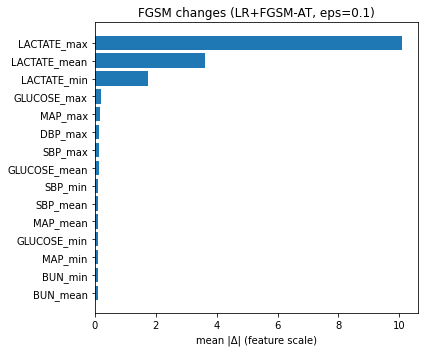

In [86]:
plot_change(rep_lr, title=f"FGSM changes (LR+FGSM-AT, eps={eps_main})",
            top=15)

In [ ]:
# for defended XGB
Xn_adv_xgb = fgsm_numeric_fast(
    pipe_xgb_def, Xn_te, Xc_te, y_te, eps=0.10,
    lo_vec=lo, hi_vec=hi, std_vec=std
)

In [85]:
rep_xgb = fgsm_change_report(Xn_te, Xn_adv_xgb, lo, hi)
display(rep_xgb.head(12))

,feature,mean_|Δ|,frac_at_lo,frac_at_hi
18,LACTATE_max,10.077744,0.0055,0.0000
4,LACTATE_mean,3.597209,0.0015,0.0000
11,LACTATE_min,1.732274,0.0000,0.0000
16,GLUCOSE_max,0.134869,0.0040,0.0045
37,MAP_max,0.110937,0.0085,0.0040
39,SBP_max,0.081753,0.0055,0.0040
7,BUN_min,0.078100,0.0090,0.0045
33,SPO2_min,0.069250,0.0055,0.0070
25,SBP_mean,0.062261,0.0045,0.0000
14,BUN_max,0.059300,0.0045,0.0065


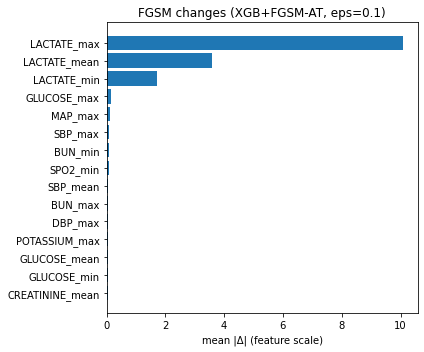

In [87]:
plot_change(rep_xgb, title=f"FGSM changes (XGB+FGSM-AT, eps={eps_main})",
            top=15)